In [24]:
from __future__ import unicode_literals, print_function, division
from io import open
import os
import unicodedata
import pickle
import string
import re
import random
import numpy as np
import pdb
from tqdm import tqdm
from torch.autograd import Variable
import pandas as pd
import matplotlib.pyplot as plt


import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
from torch.utils.data import Dataset

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [25]:
PAD_idx = 0
SOS_idx = 1
EOS_idx = 2
UNK_idx= 3
batch_size = 64
MAX_SENTENCE_LENGTH = 40

In [26]:
en_pretrained_path = './wiki-news-300d-1M.vec'
vi_pretrained_path = './cc.vi.300.vec'

In [27]:
train_en = open('iwslt-vi-en/train.tok.en' , encoding='utf-8').read().strip().split('\n')
val_en = open('iwslt-vi-en/dev.tok.en', encoding='utf-8').read().strip().split('\n')
test_en = open('iwslt-vi-en/test.tok.en', encoding='utf-8').read().strip().split('\n')
train_en[:5]

['Rachel Pike : The science behind a climate headline',
 'In 4 minutes , atmospheric chemist Rachel Pike provides a glimpse of the massive scientific effort behind the bold headlines on climate change , with her team -- one of thousands who contributed -- taking a risky flight over the rainforest in pursuit of data on a key molecule .',
 'I &apos;d like to talk to you today about the scale of the scientific effort that goes into making the headlines you see in the paper .',
 'Headlines that look like this when they have to do with climate change , and headlines that look like this when they have to do with air quality or smog .',
 'They are both two branches of the same field of atmospheric science .']

In [28]:
print(len(train_en), len(val_en), len(test_en))

133317 1268 1553


In [29]:
train_vi = open('iwslt-vi-en/train.tok.vi', encoding='utf-8').read().strip().split('\n')
val_vi = open('iwslt-vi-en/dev.tok.vi', encoding='utf-8').read().strip().split('\n')
test_vi = open('iwslt-vi-en/test.tok.vi', encoding='utf-8').read().strip().split('\n')
train_vi[:5]

['Khoa_học đằng_sau một tiêu_đề về khí_hậu',
 'Trong 4 phút , chuyên_gia hoá_học khí_quyển Rachel Pike giới_thiệu sơ_lược về những nỗ_lực khoa_học miệt_mài đằng_sau những tiêu_đề táo_bạo về biến_đổi khí_hậu , cùng với đoàn nghiên_cứu của mình - - hàng ngàn người đã cống_hiến cho dự_án này - - một chuyến bay mạo_hiểm qua rừng_già để tìm_kiếm thông_tin về một phân_tử then_chốt .',
 'Tôi muốn cho các bạn biết về sự to_lớn của những nỗ_lực khoa_học đã góp_phần làm_nên các dòng tít bạn thường thấy trên báo .',
 'Có những dòng trông như thế_này khi bàn về biến_đổi khí_hậu , và như thế_này khi nói về chất_lượng không_khí hay khói bụi .',
 'Cả hai đều là một nhánh của cùng một lĩnh_vực trong ngành khoa_học khí_quyển .']

### Transform data list to dataframe 

In [30]:
def to_dataframe(en, ch, len_raio=0.95):
    en_len_list, ch_len_list = [], []
    for en_sample, ch_sample in zip(en, ch):
        en_len_list.append(len(en_sample))
        ch_len_list.append(len(ch_sample))
    df = pd.DataFrame({'en': en, 
                       'en_len': en_len_list,
                       'ch': ch,
                       'ch_len': ch_len_list
                      })
    en_len_at_ratio = sorted(en_len_list)[int(len_raio*len(en_len_list))]
    ch_len_at_ratio = sorted(ch_len_list)[int(len_raio*len(ch_len_list))]
    print ("EN length @{}: {}, CH length @{}: {}".format(len_raio, en_len_at_ratio, len_raio, ch_len_at_ratio))
    return df, max(en_len_at_ratio, ch_len_at_ratio)

# Data Preprocessing

In [31]:
def load_vectors(fname):
    """
    load the pretrained word embeddings
    param fname: the path the to the word embedding
    return: 
            a dictionary of the {word: embedding}
    """
    fin = open(fname, 'r', encoding='utf-8', newline='\n', errors='ignore')
    n, d = map(int, fin.readline().split())
    data = {}
    for line in tqdm(fin):
        tokens = line.rstrip().split(' ')
        data[tokens[0]] = list(map(float, tokens[1:]))
    return data

In [32]:
# Get the vocabulary based on the training data
from collections import Counter

def get_vocabulary(data, VOCABULARY_SIZE=30000):
    
    en_vocab, ch_vocab = [], []
    for idx, row in data.iterrows():
        en_vocab += row['en'].split()
        ch_vocab += row['ch'].split()
    en_token_counter = Counter(en_vocab)
    ch_token_counter = Counter(ch_vocab)
    print ("Number of en words: {}, ch words: {}".format(len(en_token_counter), len(ch_token_counter)))
    en_word, _ = zip(*en_token_counter.most_common(VOCABULARY_SIZE))
    en_id2token = ['<PAD>','<SOS>','<EOS>','<UNK>'] + list(en_word)
    en_token2id = dict(zip(en_id2token, np.arange(len(en_id2token))))
    ch_word, _ = zip(*ch_token_counter.most_common(VOCABULARY_SIZE))
    ch_id2token = ['<PAD>','<SOS>','<EOS>','<UNK>'] + list(ch_word)
    ch_token2id = dict(zip(ch_id2token, np.arange(len(ch_id2token))))
    return en_id2token, en_token2id, ch_id2token, ch_token2id

In [33]:
def get_embedding_weights(whole_vec, id2token):
    """
    get the embeddings based on the word, create the embedding matrix
    param whole_vec: the dictionary of pretrained embeddings
    param id2token: the whole vocabulary
    return:
            embedding matrix
    """
    weight = np.zeros((len(id2token), len(whole_vec['sky'])))
    mask = np.zeros((len(id2token)))
    for i, word in enumerate(id2token[1:]):
        if i<3:
            weight[i+1] = np.array(np.random.randn(300))
        elif word in whole_vec.keys():
            weight[i+1] = np.array(whole_vec[word])
        else:
            weight[i+1] = weight[3]
            mask[i+1] = 1
            print ("Out of vocabulary word: ", word)   
    return weight, mask

In [34]:
def load_pickle(data_path, callback, *callback_args):
    """
    Create huge file with the callback function if not exist, otherwise load directly
    param data_path: the path of the load file if exist, otherwise the path to store the created file
    param callback: the function to generate the data if not exist
    param callback_args: the argument for the callback:
    return: 
            the data, either loaded or created by callback
    """

    data_path = data_path
    if os.path.isfile(data_path):
        print ('File exists, load from path...')
        data = pickle.load(open(data_path, 'rb'))
    else:
        print ('File not exists, creating...')
        data = callback(*callback_args)
        pickle.dump(data, open(data_path, 'wb'))
    return data

In [35]:
eng_pretrained = load_pickle('en_pretrained.pkl', load_vectors, en_pretrained_path)
vi_pretrained = load_pickle('vi_pretrained.pkl', load_vectors, vi_pretrained_path)

File exists, load from path...
File exists, load from path...


In [36]:

def normalizeVi(s):
    s = s.lower().strip()
    s =re.sub(r"[-()\"#/@;:<>{}`+=~|,]", "", s)
    s = re.sub(r"[0-9]","",s)
    s = re.sub( '\s+', ' ', s)
    return s

In [37]:
#Turn a Unicode string to plain ASCII
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn')

# Lowercase, trim, and remove non-letter characters
def normalizeString(s):
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)
    s =' '.join([word.replace('&apos',' ') for word in s.split()])
    s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)
    return s

In [38]:
def token_to_index(sentence, token2id):
    indicies_data = []
    for s in sentence:
        tokens = s.split(' ')
        index_list =[token2id[token] if token in token2id else UNK_idx for token in tokens]
        assert len(tokens) == len(index_list)
        indicies_data.append(index_list)
    return indicies_data


## Enlgish

In [39]:
normalize_train_en = [normalizeString(s) for s in train_en]
normalize_val_en = [normalizeString(s) for s in val_en]
normalize_test_en = [normalizeString(s) for s in test_en]
normalize_train_en[:5]

['rachel pike the science behind a climate headline',
 'in minutes atmospheric chemist rachel pike provides a glimpse of the massive scientific effort behind the bold headlines on climate change with her team one of thousands who contributed taking a risky flight over the rainforest in pursuit of data on a key molecule .',
 'i d like to talk to you today about the scale of the scientific effort that goes into making the headlines you see in the paper .',
 'headlines that look like this when they have to do with climate change and headlines that look like this when they have to do with air quality or smog .',
 'they are both two branches of the same field of atmospheric science .']

## Vietnamese

In [40]:
normalize_train_vi = [normalizeVi(s) for s in train_vi]
normalize_val_vi = [normalizeVi(s) for s in val_vi]
normalize_test_vi = [normalizeVi(s) for s in test_vi]
normalize_train_vi[0]

'khoa_học đằng_sau một tiêu_đề về khí_hậu'

In [41]:
train_df, pad_len = to_dataframe(normalize_train_en, normalize_train_vi)
val_df, _ = to_dataframe(normalize_val_en, normalize_val_vi)
test_df, _ = to_dataframe(normalize_test_en, normalize_test_vi)

EN length @0.95: 228, CH length @0.95: 235
EN length @0.95: 230, CH length @0.95: 238
EN length @0.95: 187, CH length @0.95: 192


In [42]:
en_id2token, en_token2id, vi_id2token, vi_token2id = get_vocabulary(train_df)

Number of en words: 41266, ch words: 33913


In [43]:
train_en_indicies = token_to_index(normalize_train_en, en_token2id)
val_en_indicies = token_to_index(normalize_val_en, en_token2id)
test_en_indicies = token_to_index(normalize_test_en, en_token2id)

In [44]:
train_vi_indicies = token_to_index(normalize_train_vi, vi_token2id)
val_vi_indicies = token_to_index(normalize_val_vi, vi_token2id)
test_vi_indicies = token_to_index(normalize_test_vi, vi_token2id)

In [45]:
train_vi_indicies[0]

[183, 1259, 8, 3129, 29, 807]

In [46]:
print ('-'*100)
eng_embedding, _ = load_pickle('eng_embedding_3.pkl', get_embedding_weights, eng_pretrained, en_id2token)

print ('-'*100)
vi_embedding, _ = load_pickle('vi_embedding_3.pkl', get_embedding_weights, vi_pretrained, vi_id2token)

----------------------------------------------------------------------------------------------------
File exists, load from path...
----------------------------------------------------------------------------------------------------
File exists, load from path...


In [47]:
vi_embedding.shape

(30004, 300)

## Data Loader

In [24]:
class LanguageDataset(Dataset):
    """
    Class that represents a train/validation/test dataset that's readable for PyTorch
    Note that this class inherits torch.utils.data.Dataset
    """

    def __init__(self, source_lan, translate_lan):
        """
        @param data_list: list of character
        @param target_list: list of targets

        """
        self.source_lan = source_lan
        self.translate_lan = translate_lan
        
        assert (len(self.source_lan) == len(self.translate_lan))

    def __len__(self):
        return len(self.source_lan)

    def __getitem__(self, key):
        """
        Triggered when you call dataset[i]
        """
        source_lan_idx = self.source_lan[key][:MAX_SENTENCE_LENGTH-1]
        translation_lan_idx = self.translate_lan[key][:MAX_SENTENCE_LENGTH-1]
        source_lan_idx.append(EOS_idx)
        translation_lan_idx.append(EOS_idx)
        
        return [source_lan_idx, translation_lan_idx, len(source_lan_idx), len(translation_lan_idx)]


In [25]:
def vocab_collate_func(batch):
    """
    Customized function for DataLoader that dynamically pads the batch so that all
    data have the same length
    """
    source_list = []
    translate_list = []
    length_list = []
    
    # padding
    for datum in batch:
        
        length_list.append(datum[2])
        s_padded_vec = np.pad(np.array(datum[0]),
                                pad_width=((0,MAX_SENTENCE_LENGTH-datum[2])),
                                mode="constant", constant_values=PAD_idx)
        source_list.append(s_padded_vec)
        t_padded_vec = np.pad(np.array(datum[1]),
                                pad_width=((0,MAX_SENTENCE_LENGTH-datum[3])),
                                mode="constant", constant_values=PAD_idx)
        translate_list.append(t_padded_vec)
        
    ind_dec_order = np.argsort(length_list)[::-1]
    source_list = np.array(source_list)[ind_dec_order]
    length_list = np.array(length_list)[ind_dec_order]
    translate_list = np.array(translate_list)[ind_dec_order]
    
    if torch.cuda.is_available and torch.has_cudnn:
        return [torch.from_numpy(np.array(source_list)).cuda(),torch.from_numpy(np.array(translate_list)).cuda()]
    else:
        return [torch.from_numpy(np.array(source_list)),torch.from_numpy(np.array(translate_list))]




In [26]:
#Build train, valid and test dataloaders
train_dataset = LanguageDataset(train_vi_indicies, train_en_indicies)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size,
                                           collate_fn=vocab_collate_func,
                                           shuffle=True)


val_dataset = LanguageDataset(val_vi_indicies, val_en_indicies )
val_loader = torch.utils.data.DataLoader(dataset=val_dataset,
                                           batch_size=batch_size,
                                           collate_fn=vocab_collate_func,
                                           shuffle=False)

test_dataset = LanguageDataset(test_vi_indicies, test_en_indicies)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                           batch_size=batch_size,
                                           collate_fn=vocab_collate_func,
                                           shuffle=False)


## Rnn Encoder

In [27]:
class EncoderRNN(nn.Module):
    def __init__(self, emb_dim, hid_dim):
        super(EncoderRNN, self).__init__()
        
        self.hid_dim = hid_dim
        self.embedding = nn.Embedding.from_pretrained(torch.from_numpy(vi_embedding), freeze=False)
        
        self.dropout = nn.Dropout(p=0.3)
        self.gru = nn.GRU(emb_dim, self.hid_dim, batch_first=True, bidirectional= True)
        

    def forward(self, inputs, hidden):
        batch_size, length = inputs.size()
        embedded = self.dropout(self.embedding(inputs).float()) # the size -1 is inferred from other dimensions
        hidden = torch.cat((hidden, hidden))
        encoder_out, hidden = self.gru(embedded, hidden)
        hidden = self._cat_directions(hidden)
        return hidden
    def _cat_directions(self, hidden):
        
        def _cat(h):
            return torch.cat([h[0:h.size(0):2], h[1:h.size(0):2]], 2)   
        hidden = _cat(hidden)  
        return hidden

    def init_hidden(self, batch_size):
        return torch.rand(1, batch_size, self.hid_dim, device=device)

## Decoder w/o Attention

In [28]:
class DecoderRNN(nn.Module):
    def __init__(self, emb_dim, hid_dim, output_dim):
        super(DecoderRNN, self).__init__()
        self.hid_dim = hid_dim *2 
        self.output_dim = output_dim
        self.dropout = nn.Dropout(p=0.3)
        self.embedding = nn.Embedding.from_pretrained(torch.from_numpy(eng_embedding), freeze=True)
        self.gru = nn.GRU(emb_dim + self.hid_dim, self.hid_dim)
        self.out = nn.Linear(self.hid_dim, output_dim)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, inputs, hidden, context):
        #input = [1, batch size]
        #hidden = [1, batch size, hid dim]
        #context = [batch size, sen len, hid dim]
        emb = self.dropout(self.embedding(inputs).float())
        emb_con = torch.cat((emb, context), dim=2)
        #emb_con =[1, batch_size, emb dim+ hid dim]
        emb_con = F.relu(emb_con)
        
        output, hidden = self.gru(emb_con, hidden)
        output = self.softmax(self.out(output[0]))
        return output, hidden

In [29]:
teacher_forcing_ratio = 1
#input_tensor: list of sentence tensor
def train(source, translate, encoder, decoder, encoder_optimizer, decoder_optimizer,
          criterion):
    
    batch_size, input_length = source.size()
    batch_size, target_length = translate.size()
    encoder_hidden = encoder.init_hidden(batch_size)
    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    loss = 0
    
    #hidden = [1, batch size, hid dim]
    #encoder_output = [batch size, sen len, hid dim]
    
    encoder_hidden = encoder(source, encoder_hidden)

    decoder_input = torch.tensor(np.array([[SOS_idx]]*batch_size).reshape(1,batch_size),device=device)
    decoder_hidden = encoder_hidden
    
    #last hidden state of the encoder is the context
    context = encoder_hidden
    
    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False
    if use_teacher_forcing:
        # Teacher forcing: Feed the target as the next input
        for i in range(target_length):
            
            #decoder_input: previous output of decoder
            #decoder_hidden: previous hidden state of decoder
            #encoder_output: last hidden layer of encoder
            decoder_output, decoder_hidden = decoder(decoder_input, decoder_hidden, context)
            loss += criterion(decoder_output, translate[:,i])
            decoder_input = translate[:,i].unsqueeze(0)  # Teacher forcing
            
    else:
        # Without teacher forcing: use its own predictions as the next input
        for i in range(target_length):
            decoder_output, decoder_hidden= decoder(decoder_input, decoder_hidden, context)
            topv, topi = decoder_output.topk(1)
            decoder_input = topi.squeeze().detach()  # detach from history as input
            #decoder_input [1, batch size] 
            decoder_input = decoder_input.unsqueeze(0)
 
            loss += criterion(decoder_output, translate[:,i])

    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item() / target_length



In [30]:
from nltk.translate.bleu_score import corpus_bleu
import sacrebleu
def evaluate(encoder, decoder, loader):
    encoder.eval()
    decoder.eval()
    input_words = []
    target_words = []
    decoded_words = []
    num_count = 0
    num_count = 0
    for i, (source, translate) in enumerate(loader):

        cur_batch_size = translate.size()[0]
            
        with torch.no_grad():
            encoder_hidden = encoder.init_hidden(cur_batch_size)
        
        input_tensor = source
        target_tensor = translate
        target_length = target_tensor.size()[1]
        encoder_hidden = encoder(input_tensor, encoder_hidden)

        decoder_input = torch.tensor(np.array([[SOS_idx]]*cur_batch_size).reshape(1,cur_batch_size),device=device)
        decoder_hidden = encoder_hidden
        
        for i in range(cur_batch_size):
            decoded_words.append([])
            input_words.append([])
            target_words.append([])
        
        for i in range(cur_batch_size):
            for ii in range(input_tensor.size()[1]):
                if vi_id2token[input_tensor.cpu().numpy()[i,ii]] != '<PAD>':
                    input_words[num_count].append(vi_id2token[input_tensor.cpu().numpy()[i,ii]])
            num_count += 1
        num_count -= cur_batch_size
        for i in range(cur_batch_size):
            for ii in range(target_tensor.size()[1]):
                if en_id2token[target_tensor.cpu().numpy()[i,ii]] != '<PAD>':
                    target_words[num_count].append(en_id2token[target_tensor.cpu().numpy()[i,ii]])
            num_count += 1
        num_count -= cur_batch_size      
        
        cur_len = np.zeros(cur_batch_size, dtype=int)
        #pdb.set_trace()
        for i in range(target_length):
            decoder_output, decoder_hidden= decoder(decoder_input, decoder_hidden, encoder_hidden)
            
            #decoder_output, decoder_hidden, decoder_attention = decoder(decoder_input, decoder_hidden, encoder_output)
            topv, topi = decoder_output.topk(1)
            decoder_input = topi.squeeze().detach()  # detach from history as input
            decoder_input = decoder_input.unsqueeze(0)
            
            topi = topi.squeeze().cpu().numpy()
            if cur_len[0] == 0:
                for i in range(len(topi)):
                    decoded_words[num_count+i].append(en_id2token[topi[i]])
                    cur_len[i] += 1
            
            else:
                for i in range(len(topi)):
                    if decoded_words[num_count+i][cur_len[i]-1] == '<EOS>':
                        continue
                    decoded_words[num_count+i].append(en_id2token[topi[i]])
                    cur_len[i] += 1
        num_count += cur_batch_size
    pre_list = []
    for pre_sentenc in decoded_words:
        pre_list.append("".join([" "+i if not i.startswith("'") and i not in string.punctuation else i for i in pre_sentenc]).strip())

    true_list = []
    for true_sentenc in target_words:
        true_list.append("".join([" "+i if not i.startswith("'") and i not in string.punctuation else i for i in true_sentenc]).strip())
    
    true_list2 = []
    true_list2.append(true_list)        
    score = sacrebleu.corpus_bleu(pre_list, true_list2)
    print('bleu score: ', score.score)
    return decoded_words,input_words, target_words, score.score
            
    
 

In [32]:
EN_EMB_DIM = 300
ZH_EMB_DIM = 300
HID_DIM = 256
OUTPUT_DIM = len(vi_id2token)
validation_score_history = []
train_loss_history = []
learning_rate=0.001
num_epoch = 10
best_score = None


encoder = EncoderRNN(ZH_EMB_DIM, HID_DIM).to(device)
decoder = DecoderRNN(EN_EMB_DIM, HID_DIM, OUTPUT_DIM).to(device)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


encoder_optimizer = optim.Adam(encoder.parameters(), lr=learning_rate)
decoder_optimizer = optim.Adam(decoder.parameters(), lr=learning_rate)
criterion = nn.NLLLoss()

for epoch in tqdm(range(num_epoch)):
    train_loss = 0 
    for i, (source, translate) in enumerate(train_loader):
        
        encoder.train()
        decoder.train()

        loss = train(source, translate, encoder, decoder,
                     encoder_optimizer, decoder_optimizer, criterion)
        
        train_loss += loss
        
        if i >0 and i % 500 ==0:
            
            _, _, _, val_score = evaluate(encoder, decoder, val_loader)
            
            print('Epoch: [{}/{}], Step: [{}/{}],  Train Loss: {},   Validation Score: {}'.format(
                  epoch+1, num_epoch, i+1, len(train_loader),  train_loss/500, val_score))
            
            train_loss_history.append(train_loss/500)
            train_loss =0
            validation_score_history.append(val_score)  
            # check if we need to earily stop the model
            stop=False
            repeat=0
            t =5
            if best_score is None:
                best_score = val_score
            elif val_score < best_score:
                repeat += 1

                if repeat >= t:
                    stop =True
                    break
            else:
                best_score = val_score
                repeat = 0
            if stop:
                print("earily stop triggered")
                break
                
    # because of the the nested loop
    if stop:
        break
    
    torch.save(encoder.state_dict(), 'vi_encoder_10.pt')
    torch.save(decoder.state_dict(), 'vi_decoder_10.pt')
    
train_loss_df = pd.DataFrame(data={"train_loss": train_loss_history})
train_loss_df.to_csv("vi_10_train_loss.csv",index=False)
val_score_df = pd.DataFrame(data={"val_score": validation_score_history})
val_score_df.to_csv('vi_10_val_score.csv',index =False)
    


  0%|          | 0/10 [00:00<?, ?it/s]
Exception in thread Thread-6:
Traceback (most recent call last):
  File "/share/apps/python3/3.6.3/intel/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/share/apps/python3/3.6.3/intel/lib/python3.6/site-packages/tqdm-4.19.4-py3.6.egg/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/home/xy990/pytorch-cpu/py3.6.3/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



bleu score:  10.360703923199841
Epoch: [1/10], Step: [501/2084],  Train Loss: 2.964506969451902,   Validation Score: 10.360703923199841
bleu score:  12.645041043734077
Epoch: [1/10], Step: [1001/2084],  Train Loss: 2.4682235786438005,   Validation Score: 12.645041043734077
bleu score:  13.607893399692527
Epoch: [1/10], Step: [1501/2084],  Train Loss: 2.312620716094971,   Validation Score: 13.607893399692527
bleu score:  13.761001689930126
Epoch: [1/10], Step: [2001/2084],  Train Loss: 2.2183939117431617,   Validation Score: 13.761001689930126


 10%|█         | 1/10 [06:21<57:11, 381.30s/it]

bleu score:  12.137557051485473
Epoch: [2/10], Step: [501/2084],  Train Loss: 2.0964323282241804,   Validation Score: 12.137557051485473
bleu score:  13.87807778821509
Epoch: [2/10], Step: [1001/2084],  Train Loss: 2.0149701494216923,   Validation Score: 13.87807778821509
bleu score:  13.975168259451305
Epoch: [2/10], Step: [1501/2084],  Train Loss: 1.993139010238647,   Validation Score: 13.975168259451305
bleu score:  15.211011137022506
Epoch: [2/10], Step: [2001/2084],  Train Loss: 1.944983475303651,   Validation Score: 15.211011137022506


 20%|██        | 2/10 [12:42<50:51, 381.40s/it]

bleu score:  15.22581442208546
Epoch: [3/10], Step: [501/2084],  Train Loss: 1.8068420978546138,   Validation Score: 15.22581442208546
bleu score:  16.5900992933173
Epoch: [3/10], Step: [1001/2084],  Train Loss: 1.8006541448593143,   Validation Score: 16.5900992933173
bleu score:  17.4176220866847
Epoch: [3/10], Step: [1501/2084],  Train Loss: 1.7918600631713852,   Validation Score: 17.4176220866847
bleu score:  15.262965922272832
Epoch: [3/10], Step: [2001/2084],  Train Loss: 1.771346390914916,   Validation Score: 15.262965922272832


 30%|███       | 3/10 [19:03<44:29, 381.31s/it]

bleu score:  16.382646124027026
Epoch: [4/10], Step: [501/2084],  Train Loss: 1.6302462965011597,   Validation Score: 16.382646124027026
bleu score:  16.822147528404994
Epoch: [4/10], Step: [1001/2084],  Train Loss: 1.6360900842666632,   Validation Score: 16.822147528404994
bleu score:  16.784208502081444
Epoch: [4/10], Step: [1501/2084],  Train Loss: 1.6353959854125988,   Validation Score: 16.784208502081444
bleu score:  17.005187680538018
Epoch: [4/10], Step: [2001/2084],  Train Loss: 1.6503977321624752,   Validation Score: 17.005187680538018


 40%|████      | 4/10 [25:25<38:07, 381.31s/it]

bleu score:  17.194325313025224
Epoch: [5/10], Step: [501/2084],  Train Loss: 1.486302209472656,   Validation Score: 17.194325313025224
bleu score:  16.963841956519737
Epoch: [5/10], Step: [1001/2084],  Train Loss: 1.522441272735597,   Validation Score: 16.963841956519737
bleu score:  16.767587520991736
Epoch: [5/10], Step: [1501/2084],  Train Loss: 1.5354338392257683,   Validation Score: 16.767587520991736
bleu score:  17.577415903369513
Epoch: [5/10], Step: [2001/2084],  Train Loss: 1.5323884815216064,   Validation Score: 17.577415903369513


 50%|█████     | 5/10 [31:46<31:46, 381.37s/it]

bleu score:  17.237987791804034
Epoch: [6/10], Step: [501/2084],  Train Loss: 1.4064562837600698,   Validation Score: 17.237987791804034
bleu score:  18.357197621700966
Epoch: [6/10], Step: [1001/2084],  Train Loss: 1.426186099243164,   Validation Score: 18.357197621700966
bleu score:  17.529015759913932
Epoch: [6/10], Step: [1501/2084],  Train Loss: 1.4495862936019899,   Validation Score: 17.529015759913932
bleu score:  16.92303178420871
Epoch: [6/10], Step: [2001/2084],  Train Loss: 1.437520096015931,   Validation Score: 16.92303178420871


 60%|██████    | 6/10 [38:08<25:25, 381.39s/it]

bleu score:  17.73759858552509
Epoch: [7/10], Step: [501/2084],  Train Loss: 1.336022355461121,   Validation Score: 17.73759858552509
bleu score:  18.530488282488076
Epoch: [7/10], Step: [1001/2084],  Train Loss: 1.352622618293762,   Validation Score: 18.530488282488076
bleu score:  17.57938283436292
Epoch: [7/10], Step: [1501/2084],  Train Loss: 1.383679906272888,   Validation Score: 17.57938283436292
bleu score:  17.43324670382229
Epoch: [7/10], Step: [2001/2084],  Train Loss: 1.391019430351257,   Validation Score: 17.43324670382229


 70%|███████   | 7/10 [44:29<19:04, 381.36s/it]

bleu score:  17.7235673944246
Epoch: [8/10], Step: [501/2084],  Train Loss: 1.2813248920440667,   Validation Score: 17.7235673944246
bleu score:  18.092261279508996
Epoch: [8/10], Step: [1001/2084],  Train Loss: 1.302189985275269,   Validation Score: 18.092261279508996
bleu score:  18.27604565268951
Epoch: [8/10], Step: [1501/2084],  Train Loss: 1.3235209808349602,   Validation Score: 18.27604565268951
bleu score:  17.93218329832515
Epoch: [8/10], Step: [2001/2084],  Train Loss: 1.3496232500076284,   Validation Score: 17.93218329832515


 80%|████████  | 8/10 [50:50<12:42, 381.36s/it]

bleu score:  17.61006612128958
Epoch: [9/10], Step: [501/2084],  Train Loss: 1.2424012481689455,   Validation Score: 17.61006612128958
bleu score:  18.7446497658419
Epoch: [9/10], Step: [1001/2084],  Train Loss: 1.2568412813186651,   Validation Score: 18.7446497658419
bleu score:  18.735242952798494
Epoch: [9/10], Step: [1501/2084],  Train Loss: 1.2886739810943602,   Validation Score: 18.735242952798494
bleu score:  17.6280763754076
Epoch: [9/10], Step: [2001/2084],  Train Loss: 1.2913117082595835,   Validation Score: 17.6280763754076


 90%|█████████ | 9/10 [57:12<06:21, 381.34s/it]

bleu score:  18.807501017526928
Epoch: [10/10], Step: [501/2084],  Train Loss: 1.195767869567873,   Validation Score: 18.807501017526928
bleu score:  18.40295705690919
Epoch: [10/10], Step: [1001/2084],  Train Loss: 1.2297134784698487,   Validation Score: 18.40295705690919
bleu score:  18.585939957029876
Epoch: [10/10], Step: [1501/2084],  Train Loss: 1.252232156562805,   Validation Score: 18.585939957029876
bleu score:  18.322974043158226
Epoch: [10/10], Step: [2001/2084],  Train Loss: 1.2631096220016478,   Validation Score: 18.322974043158226


100%|██████████| 10/10 [1:03:33<00:00, 381.32s/it]


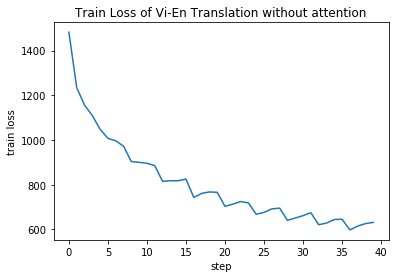

In [42]:

fig = plt.figure()
plt.plot(train_loss_history)

plt.xlabel('step')
plt.ylabel('train loss')
plt.title('Train Loss of Vi-En Translation without attention')
plt.show()
fig.savefig('train_loss_vi_10.png')

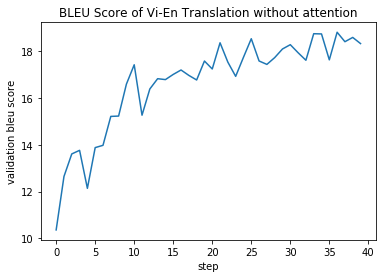

In [44]:

fig = plt.figure()
plt.plot(validation_score_history)
plt.xlabel('step')
plt.ylabel('validation bleu score')
plt.title('BLEU Score of Vi-En Translation without attention')
fig.savefig('val_score_vi_10.png')

plt.show()

In [45]:

encoder.load_state_dict(torch.load('vi_encoder_10.pt'))
decoder.load_state_dict(torch.load('vi_decoder_10.pt'))
encoder.to(device)
decoder.to(device)

DecoderRNN(
  (dropout): Dropout(p=0.3)
  (embedding): Embedding(30004, 300)
  (gru): GRU(812, 512)
  (out): Linear(in_features=512, out_features=30004, bias=True)
  (softmax): LogSoftmax()
)

In [46]:
decoded_words,input_words, target_words, score = evaluate(encoder, decoder, test_loader)

bleu score:  21.00726720202513


In [47]:
for i in range(len(decoded_words)):
    print('input: ', input_words[i])
    print('target: ', target_words[i])
    print('predict: ', decoded_words[i])
    print('-----------------------------------------------')
    print()

input:  ['tôi', 'muốn', 'rút', 'về', 'cái', 'lề_thói', 'hàng_ngày', 'và', 'sự', 'dễ_chịu', 'của', 'cuộc_sống', 'trong', 'khu', 'ngoại_ô', 'không_ai', 'hay_biết', 'người', 'bà', 'người', 'mẹ', 'và', 'hai', 'con_gái', 'kết_thúc', 'mỗi', 'ngày', 'như', 'bao', 'ngày', 'trong_suốt', 'năm', 'kể', 'cho', 'nhau', 'nghe', 'chuyện', 'trong', 'ngày', '<EOS>']
target:  ['i', 'wanted', 'to', 'retreat', 'to', 'the', 'routines', 'and', 'comfort', 'of', 'life', 'in', 'an', '<UNK>', 'suburb', 'a', 'grandmother', 'a', 'mother', 'and', 'two', 'daughters', 'ending', 'each', 'day', 'as', 'they', 'had', 'for', 'almost', 'years', 'telling', 'one', 'another', 'the', 'story', 'of', 'their', 'day', '<EOS>']
predict:  ['i', 'wanted', 'to', 'understand', 'the', 'story', 'of', 'the', 'mystic', 'and', 'the', 'gesture', 'of', 'the', 'everyday', 'and', 'the', 'mother', 'of', 'the', 'mother', 'and', 'the', 'mother', 'of', 'the', 'mother', 'and', 'the', 'mother', 'was', 'a', 'mother', 'and', 'she', 'was', 'able', 'to',

target:  ['we', 'have', 'a', 'system', 'of', 'justice', 'in', 'this', 'country', 'that', 'treats', 'you', 'much', 'better', 'if', 'you', 're', 'rich', 'and', 'guilty', 'than', 'if', 'you', 're', 'poor', 'and', 'innocent', '.', '<EOS>']
predict:  ['we', 'have', 'a', 'strong', 'system', 'with', 'a', 'good', 'system', 'if', 'you', 're', 'willing', 'to', 'get', 'married', 'with', 'the', 'poor', 'and', 'you', 're', 'not', 'disappointed', '.', '<EOS>']
-----------------------------------------------

input:  ['bằng', 'nhiều', 'cách', 'chúng_ta', 'được', 'dạy', 'để', 'tin', 'rằng', 'câu_hỏi', 'thực_sự', 'là', 'liệu', 'người_ta', 'có', 'đáng', 'phải', 'chết', 'vì', 'tội_lỗi', 'mà', 'họ', 'đã', 'gây', 'ra', '?', '<EOS>']
target:  ['in', 'many', 'ways', 'we', 've', 'been', 'taught', 'to', 'think', 'that', 'the', 'real', 'question', 'is', 'do', 'people', 'deserve', 'to', 'die', 'for', 'the', 'crimes', 'they', 've', 'committed', '?', '<EOS>']
predict:  ['how', 'many', 'we', 'taught', 'to', 'believ

-----------------------------------------------

input:  ['tôi', 'nói', 'rất', 'nhiều', 'về', 'những', 'vấn_đề', 'này', '<EOS>']
target:  ['i', 'talk', 'a', 'lot', 'about', 'these', 'issues', '.', '<EOS>']
predict:  ['i', 'm', 'talking', 'about', 'these', 'issues', '.', '<EOS>']
-----------------------------------------------

input:  ['năm', 'đã', 'có', '.', 'người', 'bị', 'tù', '<EOS>']
target:  ['in', 'there', 'were', 'people', 'in', 'jails', 'and', 'prisons', '.', '<EOS>']
predict:  ['and', 'there', 'was', 'a', 'prison', '.', '<EOS>']
-----------------------------------------------

input:  ['nhưng', 'điều', 'này', 'lại', 'khiến', 'tôi', 'quan_tâm', '<EOS>']
target:  ['it', 's', 'interesting', 'to', 'me', '.', '<EOS>']
predict:  ['but', 'it', 's', 'me', 'to', 'make', 'myself', '.', '<EOS>']
-----------------------------------------------

input:  ['chúng', 'ta', 'không', 'muốn', 'nói', 'về', 'lịch_sử', '<EOS>']
target:  ['we', 'don', 't', 'like', 'to', 'talk', 'about', 'our', 'hist

predict:  ['and', 'that', 's', 'simply', 'because', 'i', 'm', 'going', 'to', 'tell', 'you', 'a', 'story', 'about', 'the', 'next', 'year', 'i', 'will', 'tell', 'you', 'how', 'to', 'lose', 'the', 'story', '.', '<EOS>']
-----------------------------------------------

input:  ['câu_chuyện', 'nho_nhỏ', 'thứ', 'của', 'tôi', 'đó', 'là', 'khi', 'tôi', 'đang', 'là', 'người', 'đồng', 'thực_hiện', 'đưa_vào', 'giới_thiệu', 'phương_thức', 'đánh_cá', 'kéo', 'lưới', 'từ', 'đuôi', 'thuyền', 'tại', 'đông_nam_á', '<EOS>']
target:  ['my', 'third', 'little', 'story', 'is', 'that', 'i', 'was', 'an', 'accomplice', 'in', 'the', 'introduction', 'of', 'trawling', 'in', 'southeast', 'asia', '.', '<EOS>']
predict:  ['my', 'second', 'story', 'is', 'that', 'when', 'i', 'was', 'a', 'man', 'who', 'was', 'working', 'on', 'the', 'ground', 'of', 'the', 'vessel', 'that', 'was', 'built', 'by', 'the', 'fishermen', 'of', 'the', 'road', '.', '<EOS>']
-----------------------------------------------

input:  ['câu_chuyện', '

target:  ['well', 'because', 'they', 'don', 't', 'know', 'that', 'it', 'was', 'different', '.', '<EOS>']
predict:  ['because', 'they', 'weren', 't', 'quite', 'aware', 'it', 'was', 'all', '.', '<EOS>']
-----------------------------------------------

input:  ['bạn', 'chỉ', 'mất', 'đi', 'những', 'động_vật', 'quý_hiếm', '<EOS>']
target:  ['you', 'always', 'lose', 'rare', 'animals', '.', '<EOS>']
predict:  ['you', 'just', 'lose', 'the', 'animals', '.', '<EOS>']
-----------------------------------------------

input:  ['nó', 'vẫn', 'chưa', 'bị', '<UNK>', '<EOS>']
target:  ['it', 'was', 'not', 'drowned', 'yet', '.', '<EOS>']
predict:  ['it', 's', 'not', 'been', '.', '<EOS>']
-----------------------------------------------

input:  ['cám_ơn', 'rất', 'nhiều', '<EOS>']
target:  ['thank', 'you', 'very', 'much', '.', '<EOS>']
predict:  ['thank', 'you', 'very', 'much', '.', '<EOS>']
-----------------------------------------------

input:  ['bây_giờ', 'không', 'bàn', 'về', 'lựa_chọn', 'mua', 'chai'

input:  ['bây_giờ', 'cùng', 'bệnh_nhân', 'bị', 'đau_ngực', 'ấy', 'giả_dụ', 'anh', 'ta', 'ướt', 'mồ', 'hồi', 'và', 'nói', 'lắm', 'và', 'thêm', 'tí', 'mùi', 'cồn', 'vào', 'hơi_thở', 'của', 'anh', 'ta', 'và', 'đột_nhiên', 'tiền_sử', 'bệnh', 'của', 'tôi', 'bị', 'ảnh_hưởng', 'xấu', '<EOS>']
target:  ['now', 'take', 'the', 'same', 'patient', 'with', 'chest', 'pain', 'make', 'them', 'moist', 'and', '<UNK>', 'and', 'put', 'a', 'little', 'bit', 'of', 'alcohol', 'on', 'their', 'breath', 'and', 'suddenly', 'my', 'history', 'is', '<UNK>', 'with', 'contempt', '.', '<EOS>']
predict:  ['now', 'he', 's', 'suffering', 'his', 'teeth', 'he', 's', 'got', 'to', 'get', 'sick', 'and', 'he', 's', 'got', 'to', 'eat', 'his', 'teeth', 'and', 'he', 's', 'got', 'worse', 'and', 'he', 's', 'wrong', 'and', 'he', 's', 'wrong', 'at', 'the', 'end', 'of', 'my', 'stress', '.']
-----------------------------------------------

input:  ['và', 'tôi', 'muốn', 'được', 'nói', 'với', 'các', 'bạn', 'rằng', 'những', 'sai_lầm', 'tệ_

predict:  ['because', 'the', 'viewer', 'who', 'creates', 'us', 'to', 'us', 'like', 'that', 'staircase', 'and', 'creates', 'us', 'to', 'make', 'a', 'better', 'audience', 'to', 'the', 'big', 'ones', '.', '<EOS>']
-----------------------------------------------

input:  ['và', 'thế_là', 'sau_đó', 'cộng_đồng', 'này', 'được', 'tạo', 'ra', 'từ', 'những', 'người', 'biết', 'đến', 'câu_chuyện', 'cười', 'này', 'và', 'họ', 'bắt_đầu', 'nói', 'và', 'làm', 'một_số', 'điều', 'về', 'nó', '.', '<EOS>']
target:  ['and', 'so', 'then', 'this', 'community', 'formed', 'of', 'people', 'who', 'shared', 'this', 'big', 'inside', 'joke', 'and', 'they', 'started', 'talking', 'about', 'it', 'and', 'doing', 'things', 'with', 'it', '.', '<EOS>']
predict:  ['and', 'so', 'this', 'is', 'the', 'way', 'that', 'these', 'people', 'have', 'been', 'known', 'to', 'know', 'about', 'this', 'and', 'they', 'started', 'to', 'know', 'about', 'this', 'and', 'they', 'started', 'to', 'know', 'it', '.', '<EOS>']
-----------------------

predict:  ['and', 'the', 'oil', 'spill', 'started', 'to', 'start', 'and', 'oil', '.', '<EOS>']
-----------------------------------------------

input:  ['trạng_thái', 'mới', 'mà', 'thế_giới', 'đang', 'hướng', 'tới', 'là', 'gì', '?', '<EOS>']
target:  ['what', 's', 'that', 'new', 'state', 'that', 'the', 'world', 'is', 'heading', 'toward', '?', '<EOS>']
predict:  ['what', 'is', 'the', 'world', 'in', 'the', 'world', 'that', 'are', 'coming', 'to', '?', '<EOS>']
-----------------------------------------------

input:  ['và', 'chúng', 'không', 'cho', 'chúng_ta', 'biết', 'nhiều', 'lắm', '.', '<EOS>']
target:  ['and', 'they', 'don', 't', 'tell', 'us', 'much', '.', '<EOS>']
predict:  ['and', 'they', 'don', 't', 'know', 'us', 'know', '.', '<EOS>']
-----------------------------------------------

input:  ['đó', 'là', 'tất_cả', 'những', 'gì', 'có_thể', 'xảy', 'ra', '.', '<EOS>']
target:  ['that', 's', 'about', 'all', 'it', 'can', 'do', '.', '<EOS>']
predict:  ['that', 's', 'all', 'the', 'things', 

input:  ['và', 'chúng', 'đều', 'liên_kết', 'chúng_ta', 'thành', 'một', 'cộng_đồng', 'lớn', 'hơn', 'nhanh', 'hơn', 'và', 'có', 'khả_năng', 'tiến_hoá', 'xa', 'hơn', 'chúng_ta', 'trước_đây', '.', '<EOS>']
target:  ['and', 'it', 'all', 'connects', 'us', 'together', 'into', 'something', 'that', 'is', 'much', 'bigger', 'and', 'much', 'faster', 'and', 'able', 'to', 'evolve', 'than', 'what', 'we', 'were', 'before', '.', '<EOS>']
predict:  ['and', 'they', 're', 'all', 'connected', 'into', 'a', 'faster', 'and', 'we', 're', 'capable', 'of', 'the', 'ecosystem', 'that', 'we', 're', 'capable', 'and', 'far', 'far', '.', '<EOS>']
-----------------------------------------------

input:  ['và', 'tôi', 'nghĩ', 'rằng', 'đó', 'là', 'thứ', 'mà', 'chúng_ta', 'đang', 'thấy', 'ở', 'đây', 'trong', 'sự', 'bùng_nổ', 'của', 'đường_cong', 'này', '.', '<EOS>']
target:  ['and', 'i', 'think', 'that', 'that', 's', 'what', 'we', 're', 'seeing', 'here', 'in', 'this', 'explosion', 'of', 'curve', '.', '<EOS>']
predict:  ['

predict:  ['and', 'i', 'think', 'that', 's', 'really', 'important', 'that', 'we', 'don', 't', 'have', 'to', 'lose', 'the', 'word', '.', '<EOS>']
-----------------------------------------------

input:  ['họ', 'sử_dụng', 'đôi', 'bàn_tay', 'của', 'mình', 'để', 'viết', 'lên', 'những', 'ứng_dụng', 'giúp', 'chính_phủ', 'làm_việc', 'tốt', 'hơn', '.', '<EOS>']
target:  ['they', 're', 'using', 'their', 'hands', 'to', 'write', 'applications', 'that', 'make', 'government', 'work', 'better', '.', '<EOS>']
predict:  ['they', 'used', 'to', 'write', 'their', 'own', 'version', 'to', 'write', 'their', 'own', 'better', '.', '<EOS>']
-----------------------------------------------

input:  ['nếu', 'chúng_ta', 'muốn', 'chính_quyền', 'làm_việc', 'cho', 'mình', 'chúng_ta', 'phải', 'khiến', 'cho', 'hệ_thống', 'đó', 'trở_nên', 'hấp_dẫn', '.', '<EOS>']
target:  ['if', 'we', 'want', 'this', 'institution', 'to', 'work', 'for', 'us', 'we', 're', 'going', 'to', 'have', 'to', 'make', 'bureaucracy', 'sexy', '.', '<

predict:  ['so', 'the', 'first', 'principle', 'is', 'that', 'the', 'images', 'of', 'the', 'form', 'is', 'a', 'picture', '.', '<EOS>']
-----------------------------------------------

input:  ['và', 'đây', 'là', 'những', 'gì', 'chúng_tôi', 'đã', 'làm', 'chúng_tôi', 'đã', 'sử_dụng', 'giải_pháp', 'đám_đông', 'ở', 'hà_lan', '<EOS>']
target:  ['so', 'what', 'we', 'did', 'we', 'crowdsourced', 'the', 'netherlands', '.', '<EOS>']
predict:  ['and', 'this', 'is', 'what', 'we', 'decided', 'to', 'do', 'in', 'the', 'township', 'in', 'the', 'situation', '.', '<EOS>']
-----------------------------------------------

input:  ['những', 'tấm', 'ảnh', 'như', 'thế_này', 'việc', 'xây_dựng', 'diễn', 'ra', 'dọc', 'theo', 'con_đường', 'đông_đúc', '.', '<EOS>']
target:  ['photos', 'like', 'this', 'construction', 'going', 'on', 'along', 'a', 'busy', 'road', '.', '<EOS>']
predict:  ['these', 'images', 'are', 'happening', 'in', 'the', 'space', 'of', 'the', 'ground', '.', '<EOS>']
---------------------------------